In [1]:
import time
from math import *
import numpy as np
from scipy.linalg import expm, fractional_matrix_power

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])
    
# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
# s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs

def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


values = np.arange(2.50000, 2.70001, 0.00001)
# 반올림하여 3자리 소수점까지만 표시
dt_values = [round(val, 6) for val in values]

unitary_choiceList = {}

for dt in dt_values:
    unitary_choiceList[dt] = [unitary(dt, i) for i in range(5)]

# Initial state
init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave, init_wave.conj().T)



In [2]:

def rho_making(dt, predicted_comb):
     
    # rho = np.matrix(irho_init)
    rho = irho_init
    
    for i in predicted_comb:
        instant_U = unitary_choiceList[dt][i]
        rho = (instant_U @ rho @ instant_U.conj().T)
     
    return rho

def rho_target(target_theta, target_phi):
     
    # Target state
    # Theta must move first and then phi move.
    target_U = Rz(target_phi) @ Rx(target_theta) 
    irho_target = target_U @ irho_init @ target_U.conj().T
    
    return irho_target

def state_fidelity(rho_1, rho_2):
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)

def dt_optimizer(irho_target, predicted_comb):
    
    my_dt = 0
    fid = 0
    i_fid = 0
    
    for i in dt_values:
            
            if fid > i_fid:
               return my_dt, fid 
            
            irho_new = rho_making(i, predicted_comb)
            i_fid = state_fidelity(irho_new, irho_target)
        
            if fid < i_fid:
                my_dt = i
                fid = i_fid
    
    return my_dt, fid

def main(theta, phi, comb):
     
    irho_target = rho_target(theta, phi)
    
    start_time = time.time()
    
    new_dt, new_fid = dt_optimizer(irho_target, comb)
    
    end_time = time.time()
    
    print("========================================================")
    print("Result of", new_dt, "=>", new_fid, ">>>", theta, phi)
    print("========================================================")
    
    new_compt = end_time - start_time
    
    return new_dt, new_fid, new_compt

In [3]:
import os
import ast
from datetime import datetime
import pandas as pd

# Create a directory to store the results
dir = 'Data_local_optimization_results_dir'
if not os.path.exists(dir):
    os.makedirs(dir)

# CSV file name setup
date = datetime.now()
printdate = date.strftime('%Y%m%d_%H%M%S')
filename = "/Local_Optimization_0.9999_" + printdate + '.csv'

# Create an empty DataFrame and write to CSV file
df = pd.DataFrame(columns=['Case', 'gate length', 'Theta', 'Phi', 
                           'DL combination', 'DL dt', 'DL fidelity', 'DL real time', 'DL computing time', 
                           'Total combination', 'Total dt', 'Total fidelity', 'Total real time', 'Total computing time'])

df.to_csv(dir + filename, index=False)

# upload existed file - Theta, Phi, Combination, Fidelity, Computing time
upload_df = pd.read_csv('data_results/NVspin_GRU_data_random_results_20230919_142458.csv')
sample = upload_df.loc[:, ["Theta", "Phi", 'dt', 'DL combination', 'DL fidelity', 'DL real time', 'DL computing time']]
sample['DL combination'] = sample['DL combination'].apply(ast.literal_eval)

print(sample)
len(upload_df)

         Theta       Phi   dt  \
0     2.376764  2.143035  2.6   
1     1.240419  4.057858  2.6   
2     2.611981  2.592080  2.6   
3     2.557084  3.359399  2.6   
4     0.673767  4.998533  2.6   
...        ...       ...  ...   
9995  2.436158  2.715927  2.6   
9996  1.739832  3.324668  2.6   
9997  1.356168  6.017059  2.6   
9998  2.274292  5.411439  2.6   
9999  0.746675  4.931662  2.6   

                                         DL combination  DL fidelity  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 4, 4, ...      0.99726   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0.98423   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 4, 4, ...      0.98394   
3     [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 4, 4, 1, ...      0.99525   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0.99425   
...                                                 ...          ...   
9995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 4, 4, 1, ...      0.99396   
9996  [0, 0, 0, 0, 0, 0, 0,

10000

In [4]:
case = 0

for case in range(len(upload_df) - 1) : 
    
    df_theta = sample["Theta"][case]
    df_phi = sample["Phi"][case]
    df_dt = sample["dt"][case]
    df_comb = sample["DL combination"][case]
    df_fid = sample["DL fidelity"][case]
    df_tott = sample["DL real time"][case]
    df_compt = sample["DL computing time"][case]
    
    print("=================== case :", case, "===================")
    
    if df_fid < 0.9999 :
        path_dt, path_fid, path_compt = main(df_theta, df_phi, df_comb)
    else:
        path_dt = df_dt
        path_fid = df_fid
        path_compt = 0
    
    print("=================== path_dt :", path_dt, "===================")

    total_dt = path_dt
    total_fid = path_fid    
    total_path = df_comb
    total_tott = df_tott

    total_compt = df_compt + path_compt
    
    output = [['case' + str(case), len(df_comb), df_theta, df_phi, 
               df_comb, df_dt, df_fid, df_tott, df_compt,
               total_path, total_dt, total_fid, total_tott, total_compt]]
    
    # Create DataFrame and append to CSV file
    df = pd.DataFrame(output, 
                      columns=['Case', 'gate length', 'Theta', 'Phi', 
                               'DL combination', 'DL dt', 'DL fidelity', 'DL real time', 'DL computing time', 
                               'Total combination', 'Total dt', 'Total fidelity', 'Total real time', 'Total computing time'])
    
    df.to_csv(dir + filename, mode='a', header=False, index=False)


=================== case : 0 ===================
Result of 2.58295 => 0.9996326199527289 >>> 2.3767638443047194 2.143035163640519
=================== path_dt : 2.58295 ===================
=================== case : 1 ===================
Result of 2.66025 => 0.990492766276298 >>> 1.2404189277096391 4.057857945078966
=================== path_dt : 2.66025 ===================
=================== case : 2 ===================
Result of 2.63524 => 0.9936347277597022 >>> 2.611981010026818 2.5920795183854004
=================== path_dt : 2.63524 ===================
=================== case : 3 ===================
Result of 2.6188 => 0.998292125440355 >>> 2.557083572950808 3.359398745693957
=================== path_dt : 2.6188 ===================
=================== case : 4 ===================
Result of 2.61629 => 0.9943455216824489 >>> 0.6737667039753198 4.998533399949195
=================== path_dt : 2.61629 ===================
=================== case : 5 ===================
Result of 2.5705

In [ ]:
import pandas as pd

df = pd.read_csv('Data_local_optimization_results_dir/Local_Optimization_0.9999_20230927_101437.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Case                  631 non-null    object 
 1   gate length           631 non-null    int64  
 2   Theta                 631 non-null    float64
 3   Phi                   631 non-null    float64
 4   DL combination        631 non-null    object 
 5   DL dt                 631 non-null    float64
 6   DL fidelity           631 non-null    float64
 7   DL real time          631 non-null    float64
 8   DL computing time     631 non-null    float64
 9   Total combination     631 non-null    object 
 10  Total dt              631 non-null    float64
 11  Total fidelity        631 non-null    float64
 12  Total real time       631 non-null    float64
 13  Total computing time  631 non-null    float64
dtypes: float64(10), int64(1), object(3)
memory usage: 69.1+ KB


array([[<Axes: title={'center': 'gate length'}>,
        <Axes: title={'center': 'Theta'}>,
        <Axes: title={'center': 'Phi'}>],
       [<Axes: title={'center': 'DL dt'}>,
        <Axes: title={'center': 'DL fidelity'}>,
        <Axes: title={'center': 'DL real time'}>],
       [<Axes: title={'center': 'DL computing time'}>,
        <Axes: title={'center': 'Total dt'}>,
        <Axes: title={'center': 'Total fidelity'}>],
       [<Axes: title={'center': 'Total real time'}>,
        <Axes: title={'center': 'Total computing time'}>, <Axes: >]],
      dtype=object)

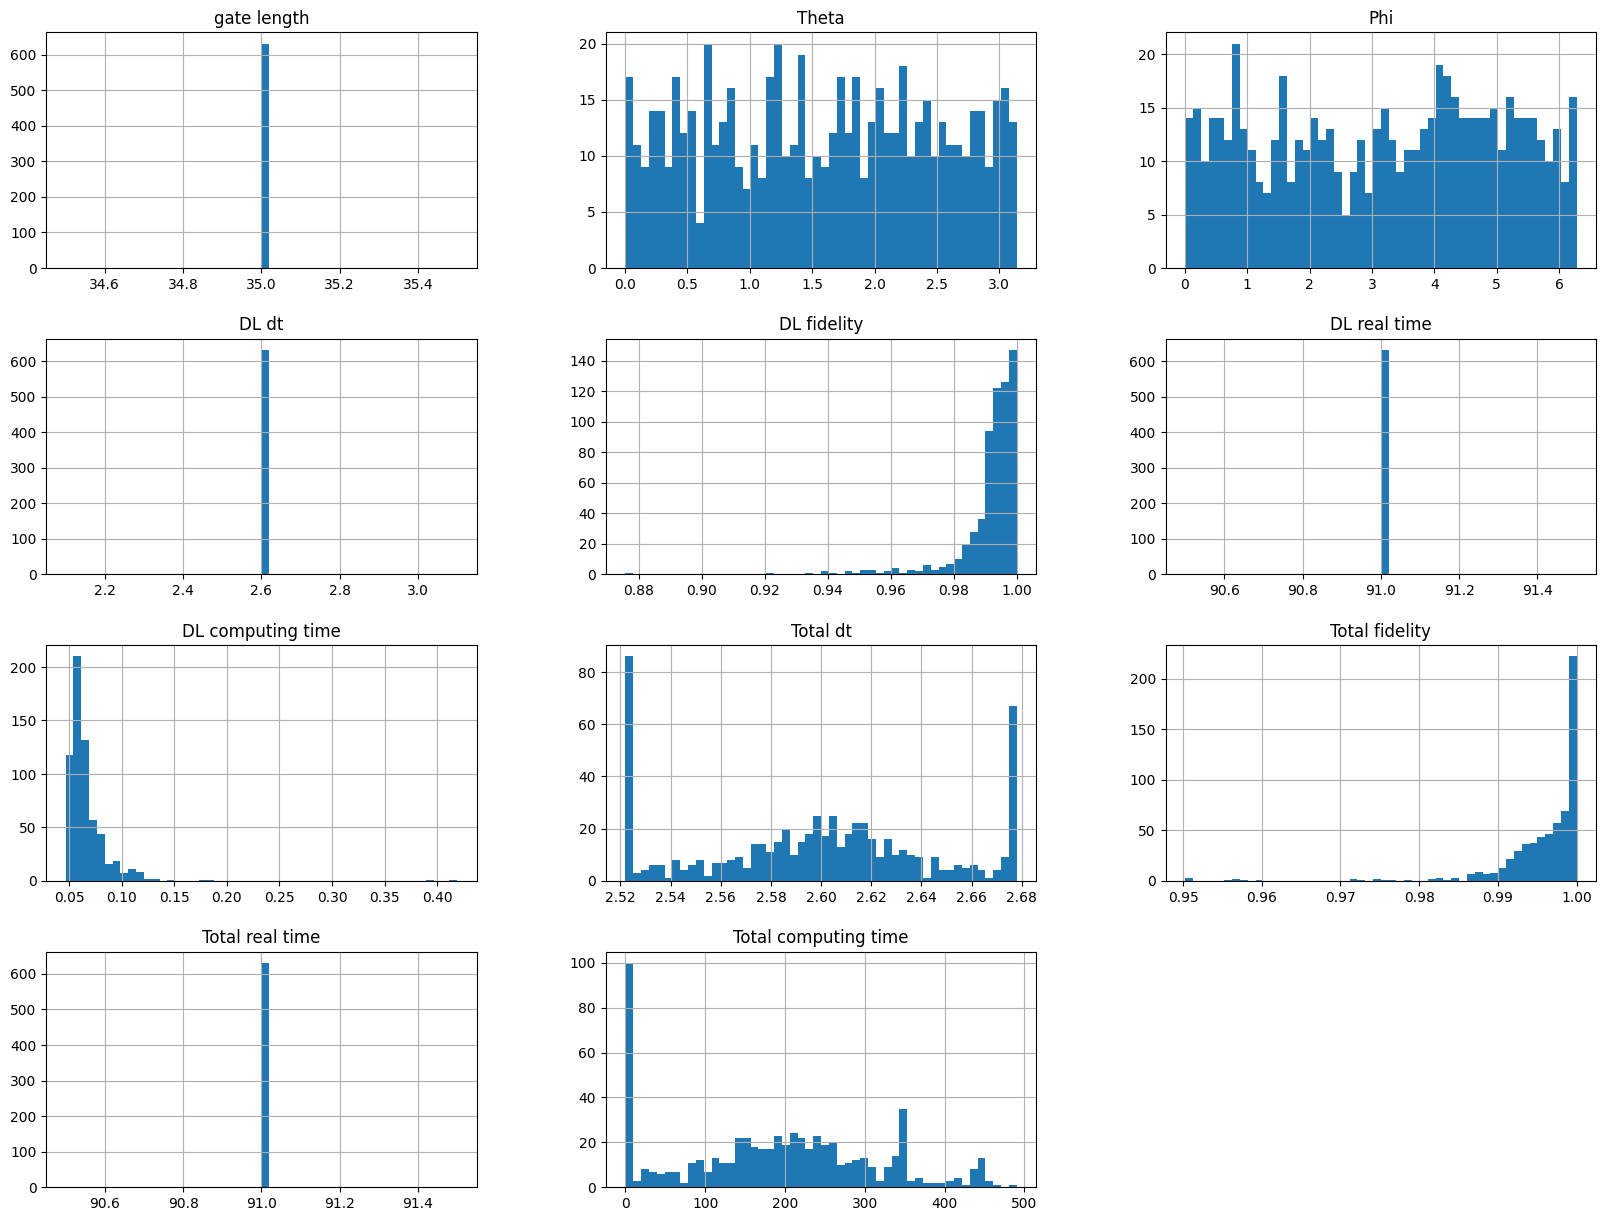

In [ ]:
import matplotlib as plt

%matplotlib inline
df.hist(bins=50, figsize=(20,15))

# 히스토그램(주어진 값 범위 수평축, 샘플 수 수직축)

<Axes: xlabel='Theta', ylabel='Phi'>

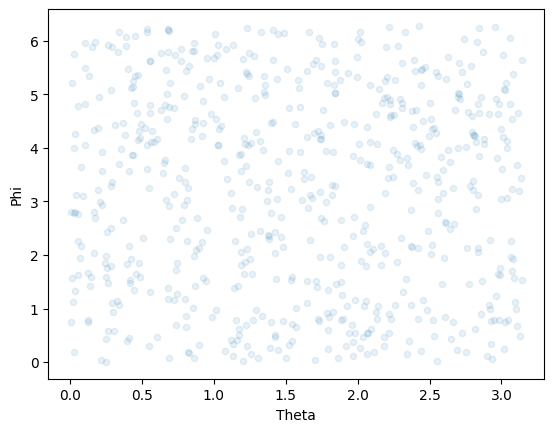

In [ ]:
df.plot(kind = "scatter", x="Theta", y="Phi", alpha=0.1)

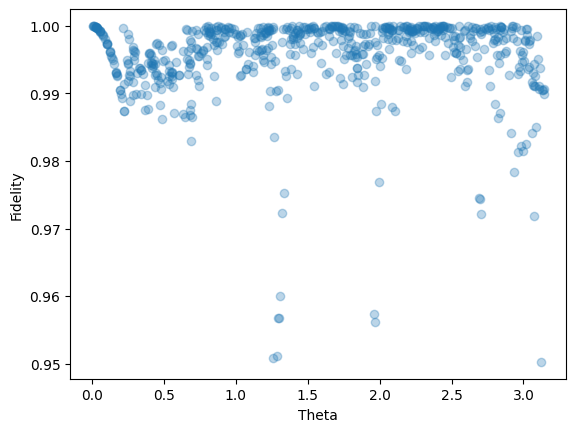

In [ ]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(df["Theta"], df["Total fidelity"], alpha=0.3)
plt.xlabel('Theta')
plt.ylabel('Fidelity')
plt.show()

In [ ]:
s = sum(df["Total fidelity"])

m = s / len(df["Total fidelity"])

c = min(df["Total fidelity"])

print(s, "/", m, "/", c)

628.270874282875 / 0.9956749196242075 / 0.9502532479670888
